# MSL Dataset

In [94]:
import pandas as pd
import numpy as np

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
msl_channels = metadata[metadata['spacecraft'] == 'MSL']['chan_id'].tolist()

## Przygotowanie danych

In [95]:
msl_train_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/train/{channel}.npy")
        msl_train_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")
    
msl_test_data = {}
for channel in msl_channels:
    try:
        data = np.load(f"data/test/{channel}.npy")
        msl_test_data[channel] = data
    except FileNotFoundError:
        print(f"{channel}: brak danych")

del data
del channel

## Działanie na danych MSL

In [96]:
# Kształt danych MSL
msl_train_shapes = {channel: msl_train_data[channel].shape for channel in msl_train_data}
print(msl_train_shapes)
del msl_train_shapes

msl_test_shapes = {channel: msl_test_data[channel].shape for channel in msl_test_data}
print(msl_test_shapes)
del msl_test_shapes

{'M-6': (1565, 55), 'M-1': (2209, 55), 'M-2': (2208, 55), 'S-2': (926, 55), 'P-10': (4308, 55), 'T-4': (2272, 55), 'T-5': (2272, 55), 'F-7': (2511, 55), 'M-3': (2037, 55), 'M-4': (2076, 55), 'M-5': (2032, 55), 'P-15': (3682, 55), 'C-1': (2158, 55), 'C-2': (764, 55), 'T-12': (1145, 55), 'T-13': (1145, 55), 'F-4': (2244, 55), 'F-5': (2598, 55), 'D-14': (3675, 55), 'T-9': (439, 55), 'P-14': (2880, 55), 'T-8': (748, 55), 'P-11': (3969, 55), 'D-15': (2074, 55), 'D-16': (1451, 55), 'M-7': (1587, 55), 'F-8': (3342, 55)}
{'M-6': (2049, 55), 'M-1': (2277, 55), 'M-2': (2277, 55), 'S-2': (1827, 55), 'P-10': (6100, 55), 'T-4': (2217, 55), 'T-5': (2218, 55), 'F-7': (5054, 55), 'M-3': (2127, 55), 'M-4': (2038, 55), 'M-5': (2303, 55), 'P-15': (2856, 55), 'C-1': (2264, 55), 'C-2': (2051, 55), 'T-12': (2430, 55), 'T-13': (2430, 55), 'F-4': (3422, 55), 'F-5': (3922, 55), 'D-14': (2625, 55), 'T-9': (1096, 55), 'P-14': (6100, 55), 'T-8': (1519, 55), 'P-11': (3535, 55), 'D-15': (2158, 55), 'D-16': (2191, 5

In [97]:
import torch

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

GPU is available :)


In [98]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class AE(nn.Module):
    def __init__(self, input_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),

        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [99]:
from sklearn.preprocessing import MinMaxScaler

def create_window(data, window_size):
    return np.array([data[i:i+window_size].flatten() for i in range(len(data) - window_size + 1)])

window_size = 200  # długość okna czasowego

# Wybór czujnika
sensor_name = msl_channels[8]
print(f"Wybrano czujnik: {sensor_name}")

sensor_train_data = msl_train_data[sensor_name]
input_dim = sensor_train_data.shape[1] * window_size

scaler = MinMaxScaler()
arr_norm = scaler.fit_transform(sensor_train_data)

# Tworzenie okien czasowych dla danych treningowych
arr_norm_windows = create_window(arr_norm, window_size)

model = AE(input_dim).to(device)


Wybrano czujnik: M-3


## Nauka na danych treningowych

In [100]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 150
batch_size = 64

X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

model = AE(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")



Epoch 1/150, Loss: 0.008579
Epoch 1/150, Loss: 0.017103
Epoch 1/150, Loss: 0.025539
Epoch 1/150, Loss: 0.033839
Epoch 1/150, Loss: 0.041918
Epoch 1/150, Loss: 0.049636
Epoch 1/150, Loss: 0.056770
Epoch 1/150, Loss: 0.062993
Epoch 1/150, Loss: 0.068097
Epoch 1/150, Loss: 0.071828
Epoch 1/150, Loss: 0.074044
Epoch 1/150, Loss: 0.075224
Epoch 1/150, Loss: 0.075842
Epoch 1/150, Loss: 0.076211
Epoch 1/150, Loss: 0.076537
Epoch 1/150, Loss: 0.076849
Epoch 1/150, Loss: 0.077172
Epoch 1/150, Loss: 0.077483
Epoch 1/150, Loss: 0.077784
Epoch 1/150, Loss: 0.078098
Epoch 1/150, Loss: 0.078411
Epoch 1/150, Loss: 0.078729
Epoch 1/150, Loss: 0.079039
Epoch 1/150, Loss: 0.079337
Epoch 1/150, Loss: 0.079647
Epoch 1/150, Loss: 0.079953
Epoch 1/150, Loss: 0.080263
Epoch 1/150, Loss: 0.080577
Epoch 1/150, Loss: 0.080885
Epoch 2/150, Loss: 0.000320
Epoch 2/150, Loss: 0.000633
Epoch 2/150, Loss: 0.000965
Epoch 2/150, Loss: 0.001284
Epoch 2/150, Loss: 0.001593
Epoch 2/150, Loss: 0.001897
Epoch 2/150, Loss: 0

# Autoencoder na danych testowych

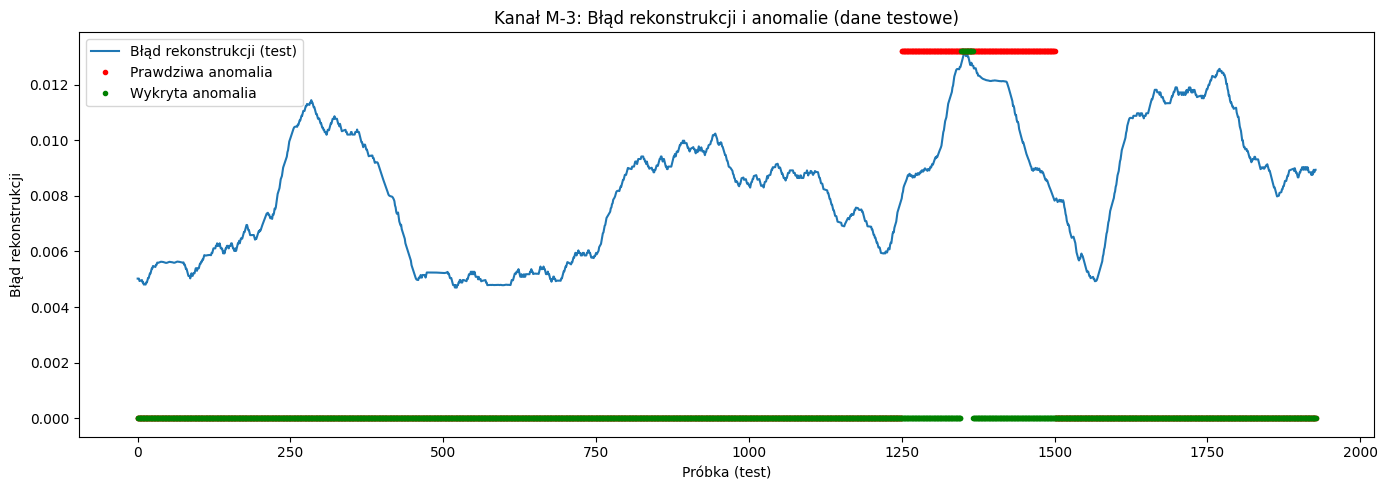

Confusion matrix (test):
[[1677    0]
 [ 231   20]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.94      1677
     Anomaly       1.00      0.08      0.15       251

    accuracy                           0.88      1928
   macro avg       0.94      0.54      0.54      1928
weighted avg       0.89      0.88      0.83      1928

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA


In [101]:
# Normalizacja oraz wczytanie danych testowych 
sensor_test_data = msl_test_data[sensor_name]
arr_test_norm = scaler.transform(sensor_test_data)
def create_windows(data, window_size):
    return np.array([data[i:i+window_size].flatten() for i in range(len(data) - window_size + 1)])
arr_test_norm_windows = create_windows(arr_test_norm, window_size)
X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)

# Rekonstrukcja i obliczenie błędu rekonstrukcji na danych testowych
model.eval()
with torch.no_grad():
    recon = model(X_test).cpu().numpy()
recon_error = np.mean((arr_test_norm_windows - recon) ** 2, axis=1)   

# Wykrywanie anomalii na danych testowych
threshold = np.percentile(recon_error, 99)
predicted_anomaly = (recon_error > threshold).astype(int)

# Prawdziwe anomalie z labeled_anomalies.csv dla testowych indeksów
anomaly_row = metadata[metadata['chan_id'] == sensor_name]
anomaly_sequences = []
if not anomaly_row.empty:
    anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

true_anomaly = np.zeros(len(recon_error), dtype=int)   
for seq in anomaly_sequences:
    start, end = seq
    true_anomaly[start:min(end+1, len(true_anomaly))] = 1

# Wizualizacja wyników na danych testowych
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(14, 5))
plt.plot(recon_error, label="Błąd rekonstrukcji (test)")
plt.plot(true_anomaly * np.max(recon_error), 'r.', label="Prawdziwa anomalia")
plt.plot(predicted_anomaly * np.max(recon_error), 'g.', label="Wykryta anomalia")
plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
plt.xlabel("Próbka (test)")
plt.ylabel("Błąd rekonstrukcji")
plt.legend()
plt.tight_layout()
plt.show()

print("Confusion matrix (test):")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report (test):")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

# Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
detected_ranges = [] 
remaining_sequences = anomaly_sequences.copy()

for seq in anomaly_sequences:
    start, end = seq
    if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
        detected_ranges.append(seq)

# Wypisanie wyników
print("Wynik sprawdzania anomalii względem metadanych:")
for seq in anomaly_sequences:
    if seq in detected_ranges:
        print(f"Anomalia {seq}: WYKRYTA")
    else:
        print(f"Anomalia {seq}: NIEWYKRYTA")


# Dla wszystkich czujników MSL


Czujnik: M-6
Epoch 1/80, Loss: 0.216599
Epoch 17/80, Loss: 0.008789
Epoch 33/80, Loss: 0.008166
Epoch 49/80, Loss: 0.008242
Epoch 65/80, Loss: 0.008146


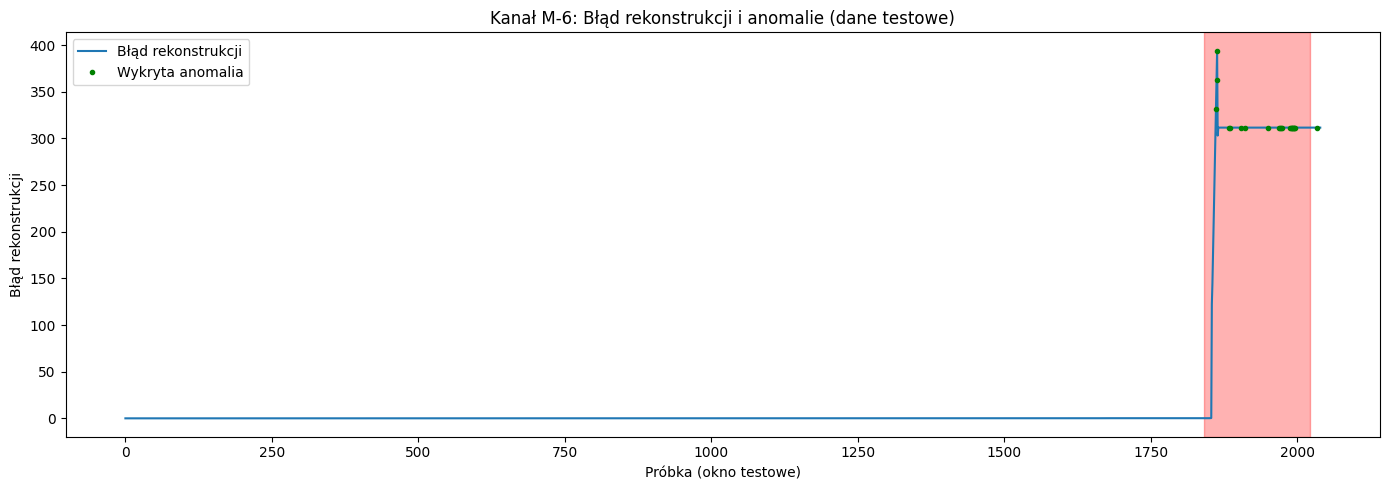

Confusion matrix (test):
[[1858    1]
 [ 161   20]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96      1859
     Anomaly       0.95      0.11      0.20       181

    accuracy                           0.92      2040
   macro avg       0.94      0.55      0.58      2040
weighted avg       0.92      0.92      0.89      2040

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1850, 2030]: WYKRYTA

Czujnik: M-1
Epoch 1/80, Loss: 0.176673
Epoch 17/80, Loss: 0.005450
Epoch 33/80, Loss: 0.005415
Epoch 49/80, Loss: 0.005344
Epoch 65/80, Loss: 0.005297


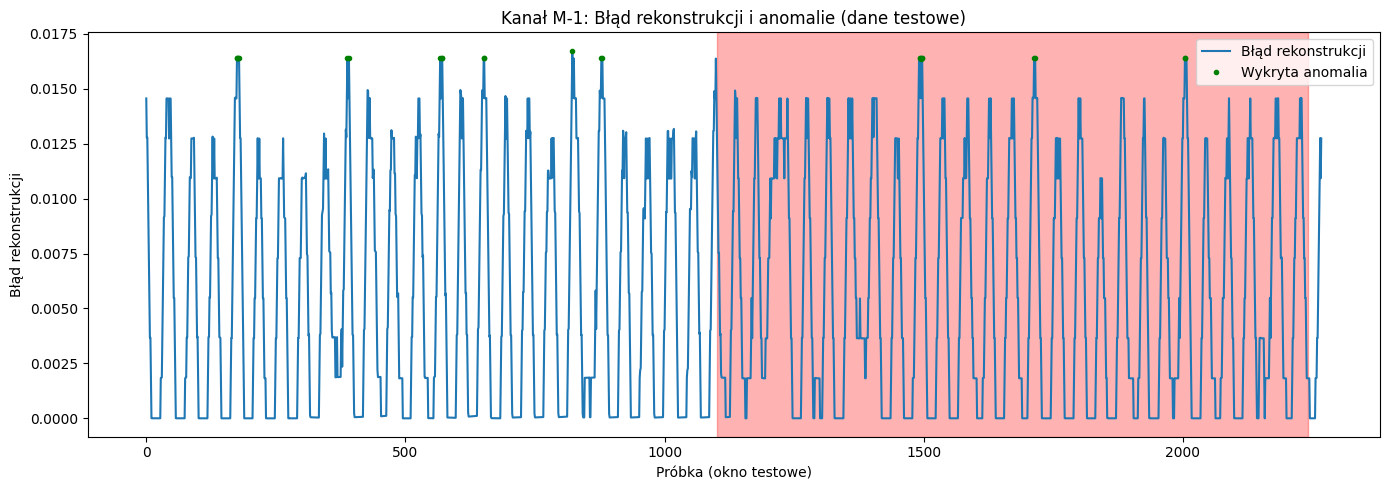

Confusion matrix (test):
[[1113   14]
 [1132    9]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      1127
     Anomaly       0.39      0.01      0.02      1141

    accuracy                           0.49      2268
   macro avg       0.44      0.50      0.34      2268
weighted avg       0.44      0.49      0.34      2268

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: M-2
Epoch 1/80, Loss: 0.181225
Epoch 17/80, Loss: 0.005374
Epoch 33/80, Loss: 0.005312
Epoch 49/80, Loss: 0.005408
Epoch 65/80, Loss: 0.005373


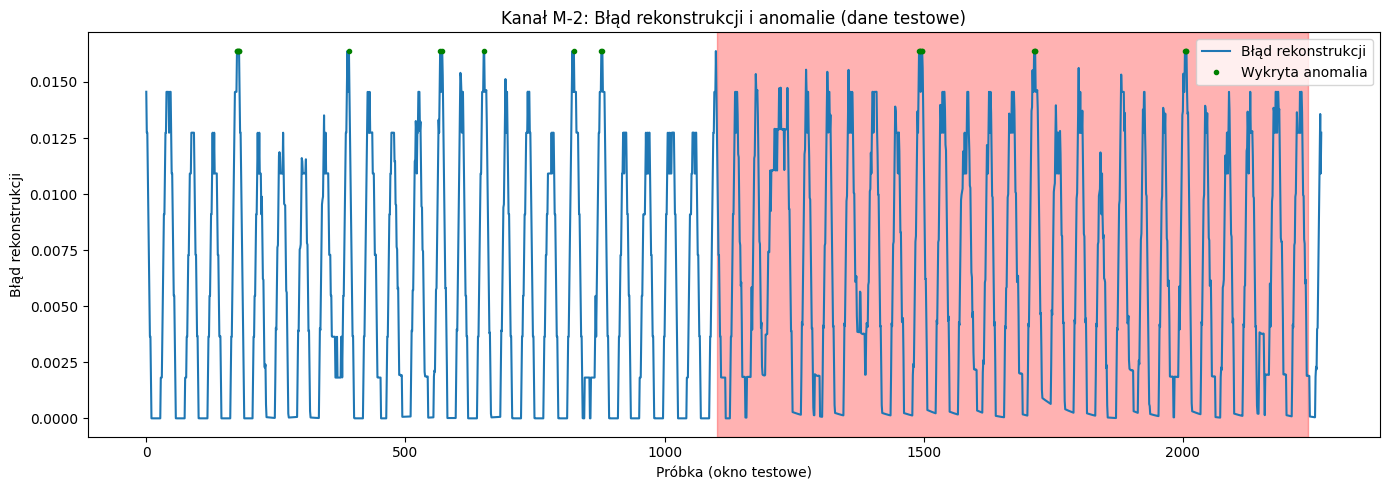

Confusion matrix (test):
[[1115   12]
 [1130   11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      1127
     Anomaly       0.48      0.01      0.02      1141

    accuracy                           0.50      2268
   macro avg       0.49      0.50      0.34      2268
weighted avg       0.49      0.50      0.34      2268

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1110, 2250]: WYKRYTA

Czujnik: S-2
Epoch 1/80, Loss: 0.237729
Epoch 17/80, Loss: 0.012695
Epoch 33/80, Loss: 0.012428
Epoch 49/80, Loss: 0.011884
Epoch 65/80, Loss: 0.011614


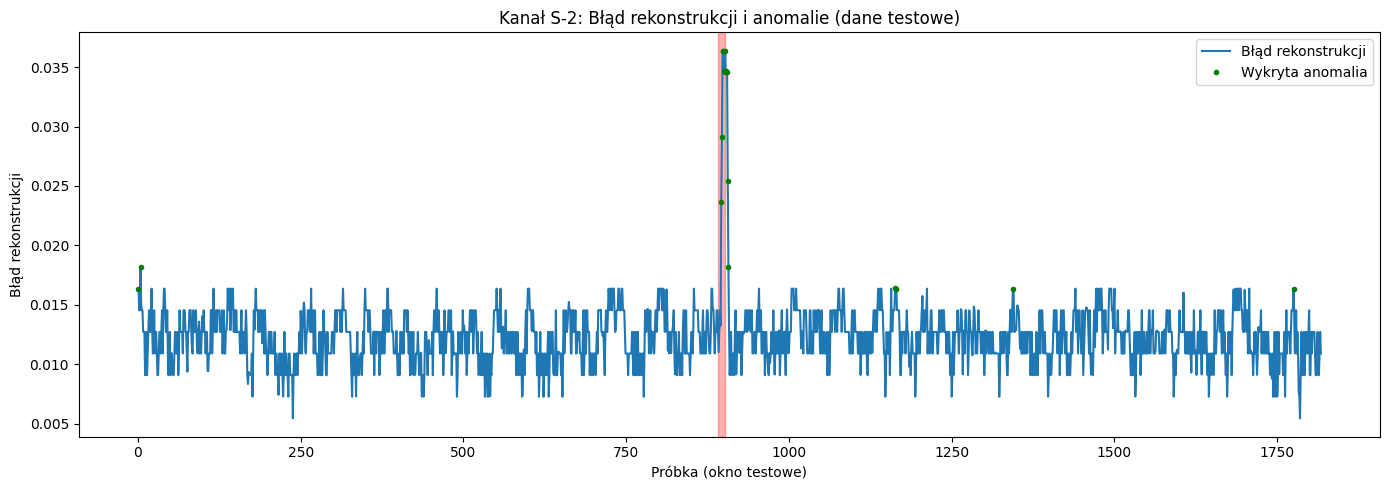

Confusion matrix (test):
[[1794   13]
 [   5    6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      1807
     Anomaly       0.32      0.55      0.40        11

    accuracy                           0.99      1818
   macro avg       0.66      0.77      0.70      1818
weighted avg       0.99      0.99      0.99      1818

Wynik sprawdzania anomalii względem metadanych:
Anomalia [900, 910]: WYKRYTA

Czujnik: P-10
Epoch 1/80, Loss: 0.090668
Epoch 17/80, Loss: 0.002396
Epoch 33/80, Loss: 0.002343
Epoch 49/80, Loss: 0.000639
Epoch 65/80, Loss: 0.000495


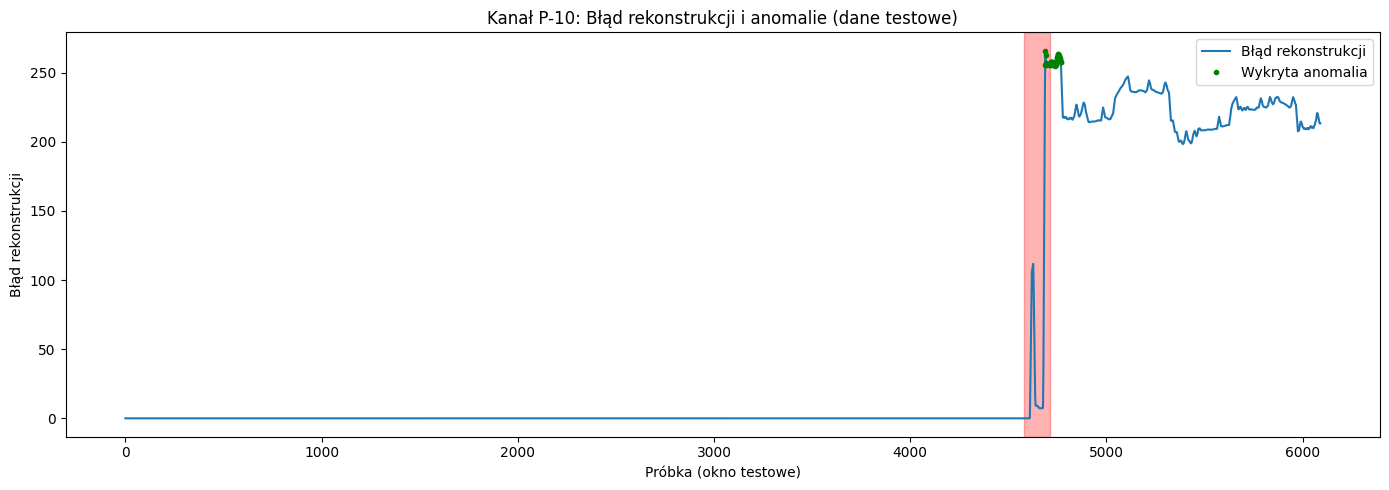

Confusion matrix (test):
[[5908   52]
 [ 122    9]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99      5960
     Anomaly       0.15      0.07      0.09       131

    accuracy                           0.97      6091
   macro avg       0.56      0.53      0.54      6091
weighted avg       0.96      0.97      0.97      6091

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4590, 4720]: WYKRYTA

Czujnik: T-4
Epoch 1/80, Loss: 0.174801
Epoch 17/80, Loss: 0.005460
Epoch 33/80, Loss: 0.005166
Epoch 49/80, Loss: 0.005048
Epoch 65/80, Loss: 0.004970


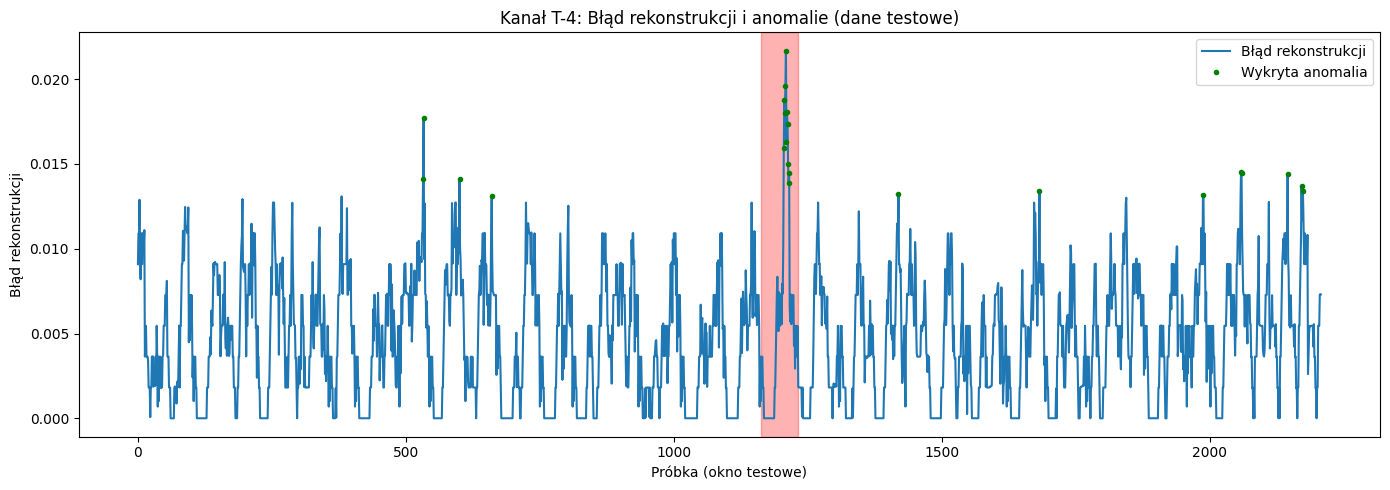

Confusion matrix (test):
[[2127   12]
 [  58   11]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98      2139
     Anomaly       0.48      0.16      0.24        69

    accuracy                           0.97      2208
   macro avg       0.73      0.58      0.61      2208
weighted avg       0.96      0.97      0.96      2208

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1172, 1240]: WYKRYTA

Czujnik: T-5
Epoch 1/80, Loss: 0.188059
Epoch 17/80, Loss: 0.004873
Epoch 33/80, Loss: 0.004882
Epoch 49/80, Loss: 0.004866
Epoch 65/80, Loss: 0.004861


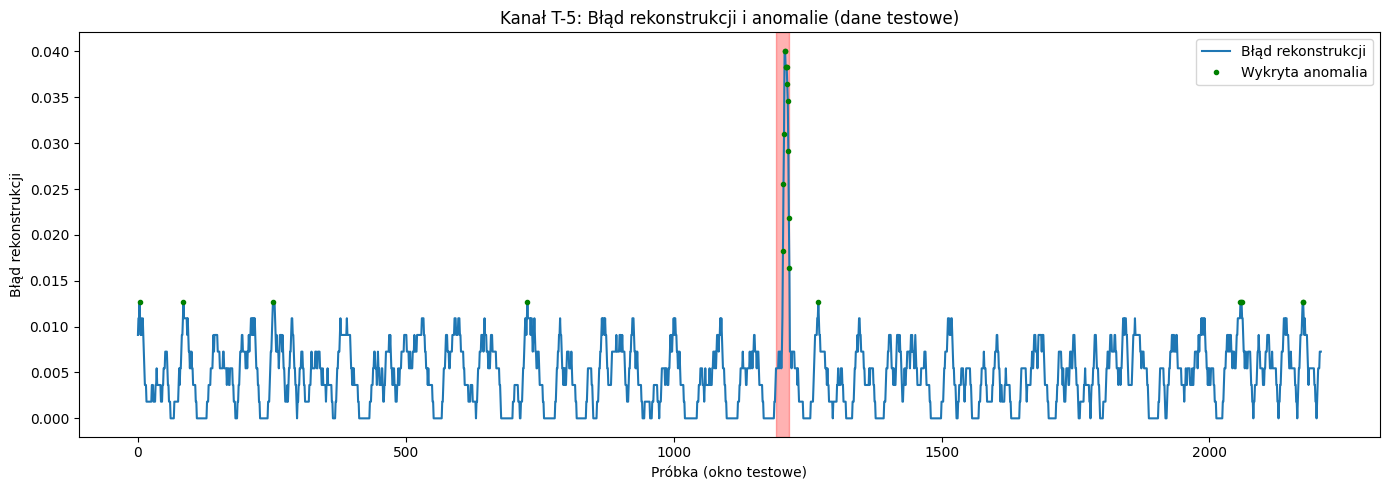

Confusion matrix (test):
[[2173   10]
 [  13   13]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      2183
     Anomaly       0.57      0.50      0.53        26

    accuracy                           0.99      2209
   macro avg       0.78      0.75      0.76      2209
weighted avg       0.99      0.99      0.99      2209

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1200, 1225]: WYKRYTA

Czujnik: F-7
Epoch 1/80, Loss: 0.176416
Epoch 17/80, Loss: 0.003117
Epoch 33/80, Loss: 0.002377
Epoch 49/80, Loss: 0.002067
Epoch 65/80, Loss: 0.001876


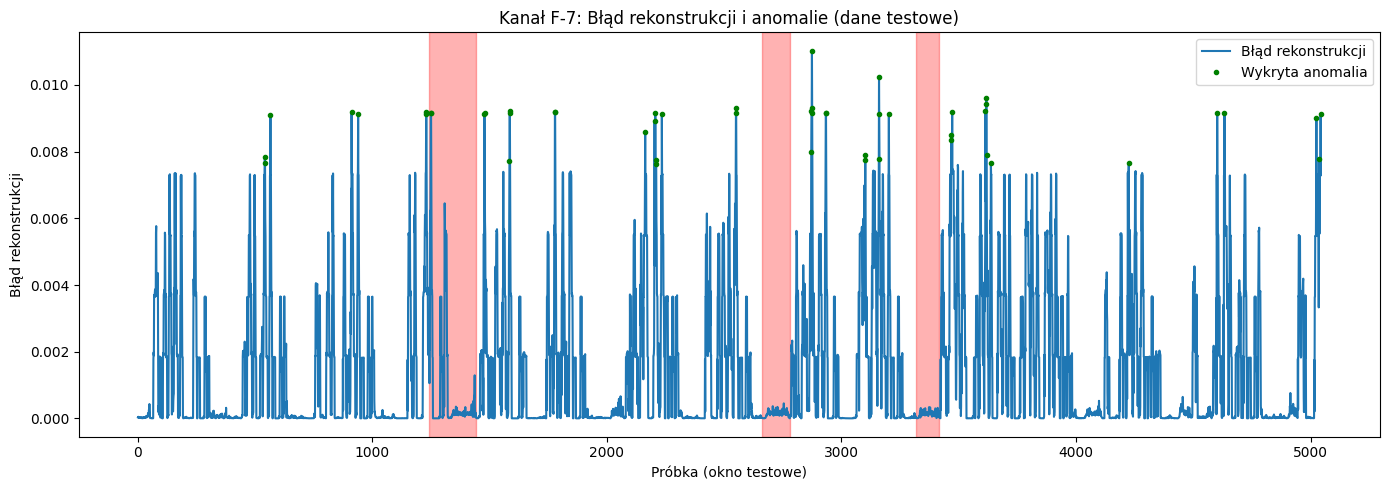

Confusion matrix (test):
[[4573   49]
 [ 421    2]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95      4622
     Anomaly       0.04      0.00      0.01       423

    accuracy                           0.91      5045
   macro avg       0.48      0.50      0.48      5045
weighted avg       0.84      0.91      0.87      5045

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1450]: WYKRYTA
Anomalia [2670, 2790]: NIEWYKRYTA
Anomalia [3325, 3425]: NIEWYKRYTA

Czujnik: M-3
Epoch 1/80, Loss: 0.178806
Epoch 17/80, Loss: 0.007133
Epoch 33/80, Loss: 0.007107
Epoch 49/80, Loss: 0.007037
Epoch 65/80, Loss: 0.007032


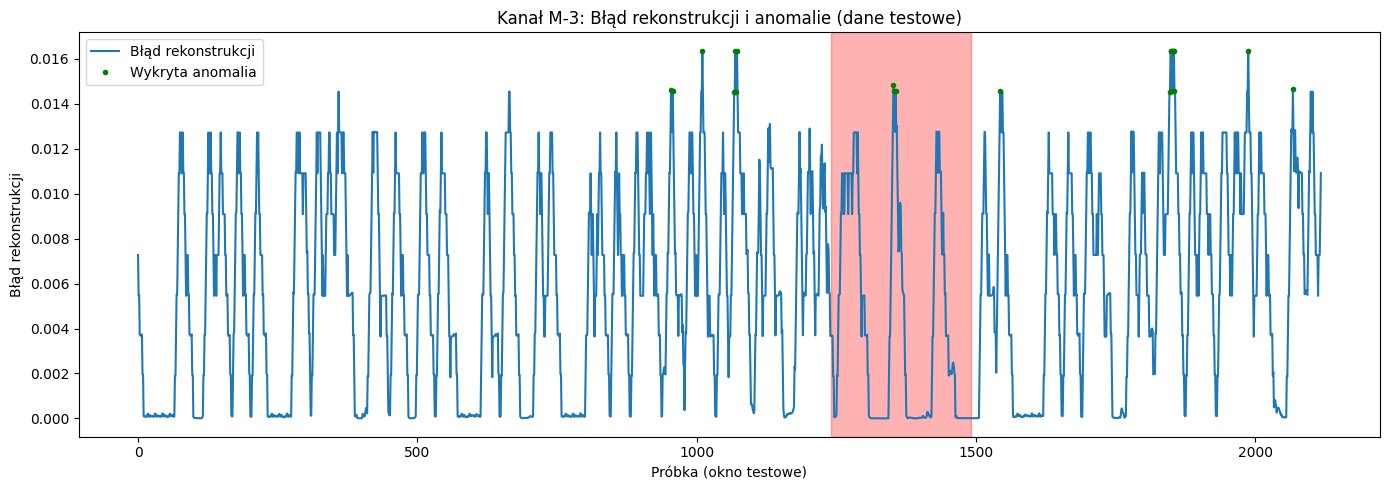

Confusion matrix (test):
[[1848   19]
 [ 248    3]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93      1867
     Anomaly       0.14      0.01      0.02       251

    accuracy                           0.87      2118
   macro avg       0.51      0.50      0.48      2118
weighted avg       0.79      0.87      0.82      2118

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-4
Epoch 1/80, Loss: 0.166799
Epoch 17/80, Loss: 0.007131
Epoch 33/80, Loss: 0.006989
Epoch 49/80, Loss: 0.006866
Epoch 65/80, Loss: 0.006902


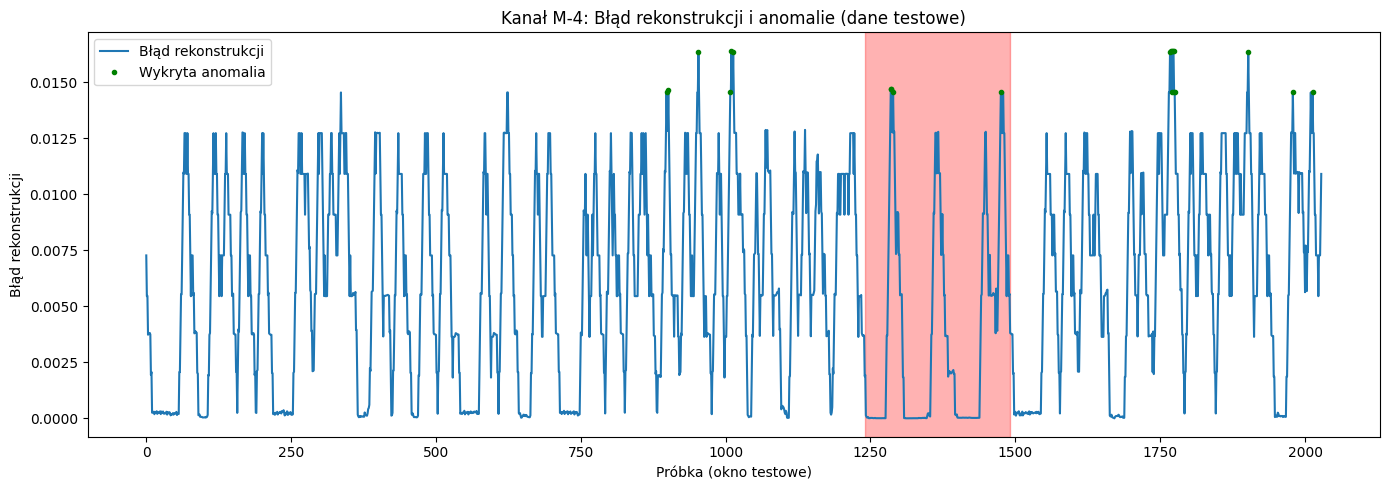

Confusion matrix (test):
[[1761   17]
 [ 247    4]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93      1778
     Anomaly       0.19      0.02      0.03       251

    accuracy                           0.87      2029
   macro avg       0.53      0.50      0.48      2029
weighted avg       0.79      0.87      0.82      2029

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1500]: WYKRYTA

Czujnik: M-5
Epoch 1/80, Loss: 0.193068
Epoch 17/80, Loss: 0.006332
Epoch 33/80, Loss: 0.006078
Epoch 49/80, Loss: 0.005822
Epoch 65/80, Loss: 0.004952


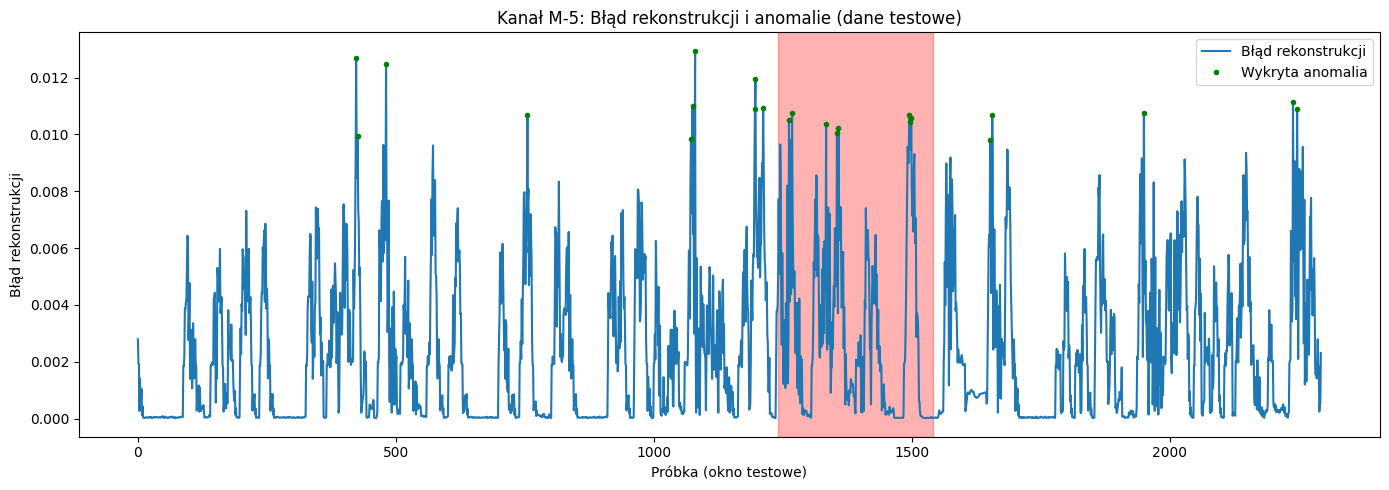

Confusion matrix (test):
[[1978   15]
 [ 293    8]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.87      0.99      0.93      1993
     Anomaly       0.35      0.03      0.05       301

    accuracy                           0.87      2294
   macro avg       0.61      0.51      0.49      2294
weighted avg       0.80      0.87      0.81      2294

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1250, 1550]: WYKRYTA

Czujnik: P-15
Epoch 1/80, Loss: 0.101868
Epoch 17/80, Loss: 0.001468
Epoch 33/80, Loss: 0.001453
Epoch 49/80, Loss: 0.001455
Epoch 65/80, Loss: 0.001454


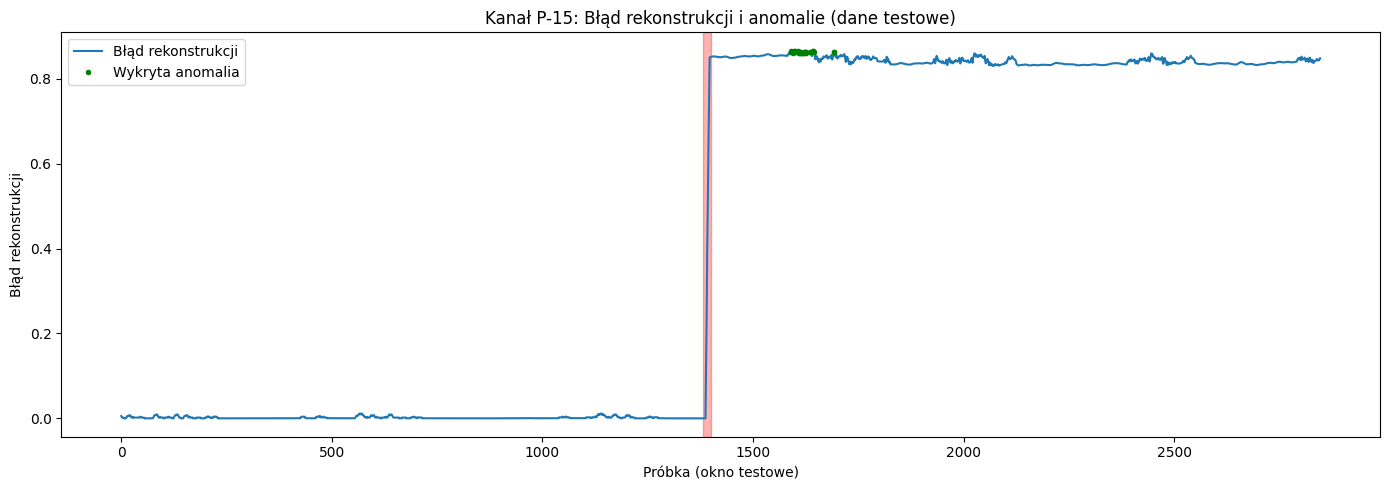

Confusion matrix (test):
[[2797   29]
 [  21    0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2826
     Anomaly       0.00      0.00      0.00        21

    accuracy                           0.98      2847
   macro avg       0.50      0.49      0.50      2847
weighted avg       0.99      0.98      0.98      2847

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1390, 1410]: NIEWYKRYTA

Czujnik: C-1
Epoch 1/80, Loss: 0.193029
Epoch 17/80, Loss: 0.005228
Epoch 33/80, Loss: 0.005123
Epoch 49/80, Loss: 0.004783
Epoch 65/80, Loss: 0.004764


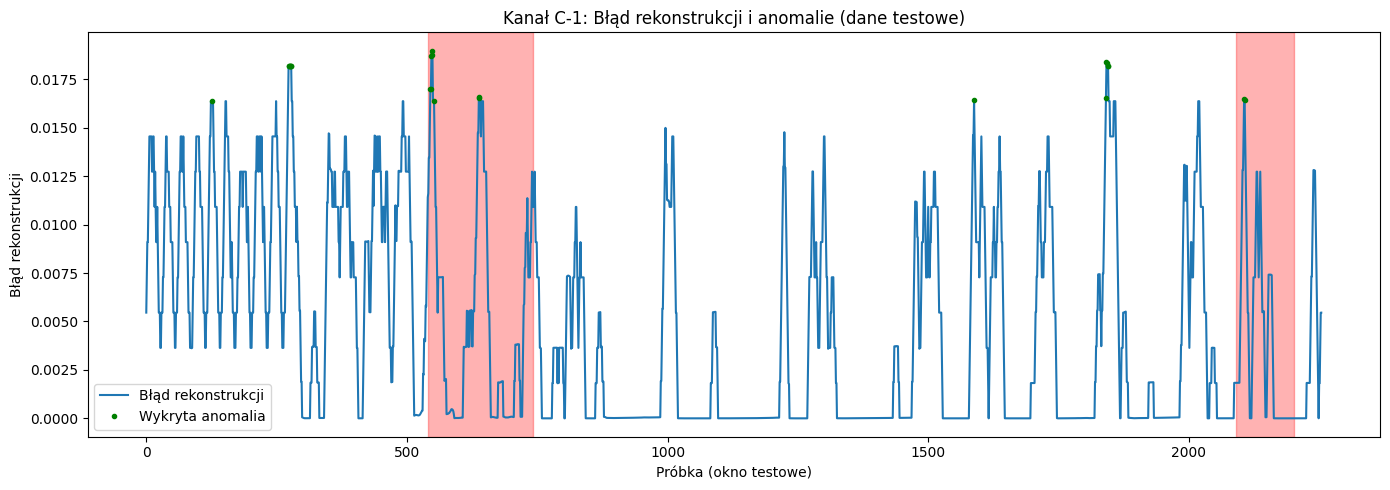

Confusion matrix (test):
[[1930   13]
 [ 302   10]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.86      0.99      0.92      1943
     Anomaly       0.43      0.03      0.06       312

    accuracy                           0.86      2255
   macro avg       0.65      0.51      0.49      2255
weighted avg       0.81      0.86      0.80      2255

Wynik sprawdzania anomalii względem metadanych:
Anomalia [550, 750]: WYKRYTA
Anomalia [2100, 2210]: WYKRYTA

Czujnik: C-2
Epoch 1/80, Loss: 0.243447
Epoch 17/80, Loss: 0.010465
Epoch 33/80, Loss: 0.009698
Epoch 49/80, Loss: 0.006658
Epoch 65/80, Loss: 0.004793


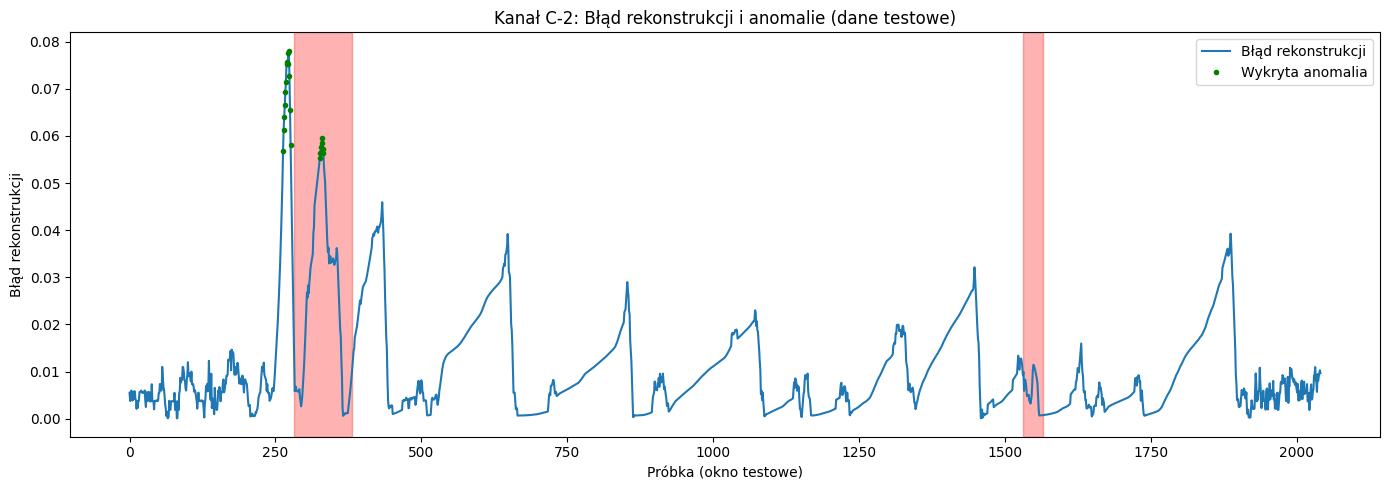

Confusion matrix (test):
[[1891   14]
 [ 130    7]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      1905
     Anomaly       0.33      0.05      0.09       137

    accuracy                           0.93      2042
   macro avg       0.63      0.52      0.53      2042
weighted avg       0.90      0.93      0.90      2042

Wynik sprawdzania anomalii względem metadanych:
Anomalia [290, 390]: WYKRYTA
Anomalia [1540, 1575]: NIEWYKRYTA

Czujnik: T-12
Epoch 1/80, Loss: 0.234113
Epoch 17/80, Loss: 0.001345
Epoch 33/80, Loss: 0.000879
Epoch 49/80, Loss: 0.000868
Epoch 65/80, Loss: 0.000865


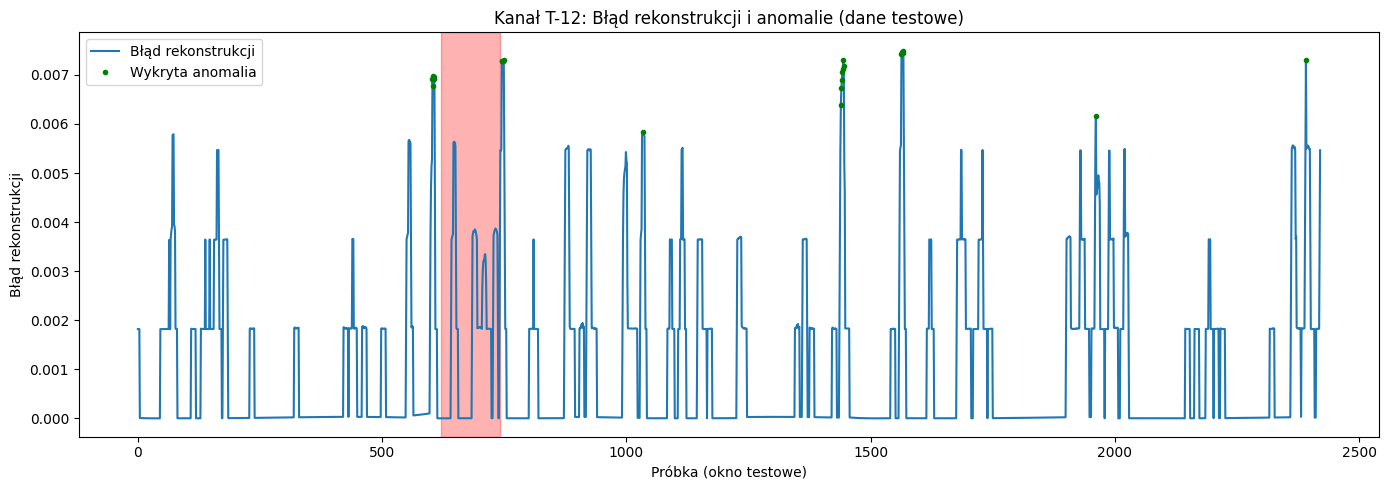

Confusion matrix (test):
[[2275   25]
 [ 121    0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97      2300
     Anomaly       0.00      0.00      0.00       121

    accuracy                           0.94      2421
   macro avg       0.47      0.49      0.48      2421
weighted avg       0.90      0.94      0.92      2421

Wynik sprawdzania anomalii względem metadanych:
Anomalia [630, 750]: NIEWYKRYTA

Czujnik: T-13
Epoch 1/80, Loss: 0.234195
Epoch 17/80, Loss: 0.001085
Epoch 33/80, Loss: 0.000839
Epoch 49/80, Loss: 0.000833
Epoch 65/80, Loss: 0.000830


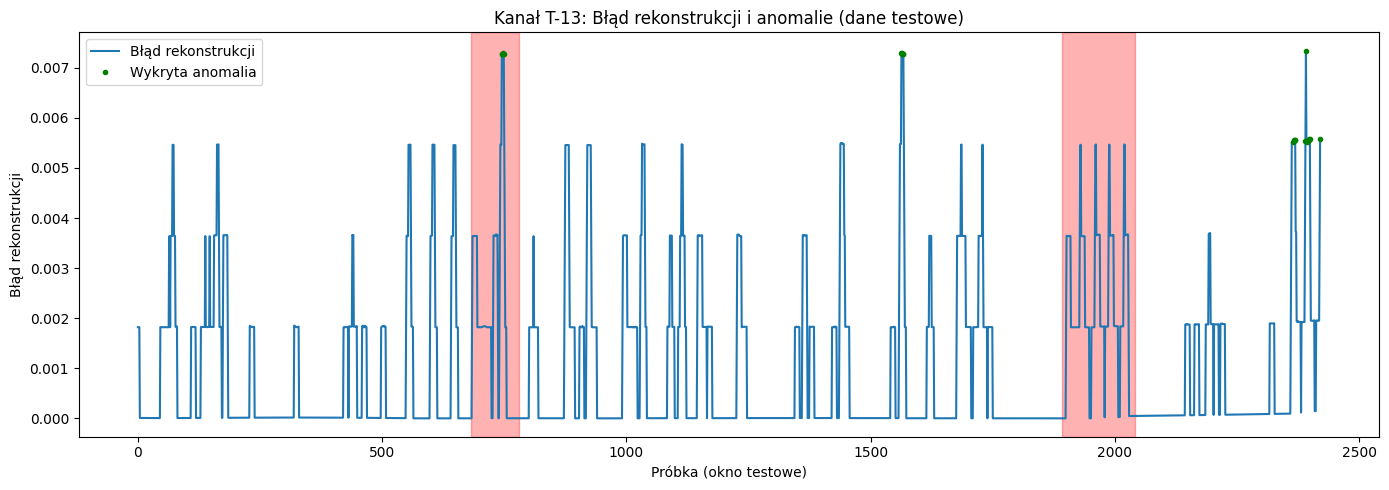

Confusion matrix (test):
[[2149   20]
 [ 247    5]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.90      0.99      0.94      2169
     Anomaly       0.20      0.02      0.04       252

    accuracy                           0.89      2421
   macro avg       0.55      0.51      0.49      2421
weighted avg       0.82      0.89      0.85      2421

Wynik sprawdzania anomalii względem metadanych:
Anomalia [690, 790]: WYKRYTA
Anomalia [1900, 2050]: NIEWYKRYTA

Czujnik: F-4
Epoch 1/80, Loss: 0.186973
Epoch 17/80, Loss: 0.002499
Epoch 33/80, Loss: 0.002495
Epoch 49/80, Loss: 0.002434
Epoch 65/80, Loss: 0.002448


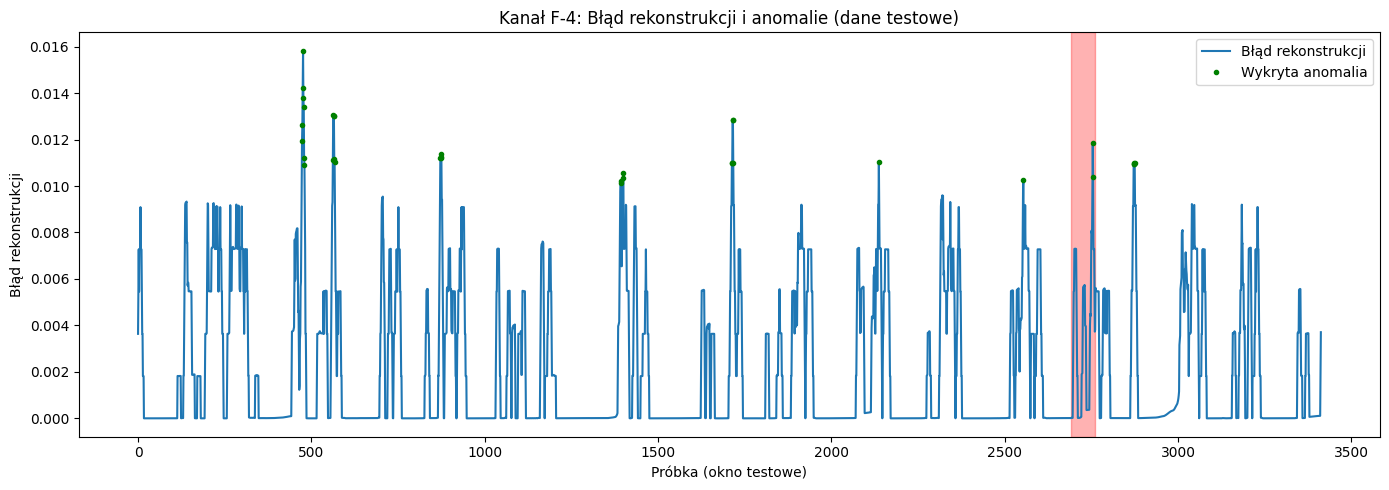

Confusion matrix (test):
[[3309   33]
 [  69    2]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98      3342
     Anomaly       0.06      0.03      0.04        71

    accuracy                           0.97      3413
   macro avg       0.52      0.51      0.51      3413
weighted avg       0.96      0.97      0.97      3413

Wynik sprawdzania anomalii względem metadanych:
Anomalia [2700, 2770]: WYKRYTA

Czujnik: F-5
Epoch 1/80, Loss: 0.173440
Epoch 17/80, Loss: 0.002921
Epoch 33/80, Loss: 0.002249
Epoch 49/80, Loss: 0.002235
Epoch 65/80, Loss: 0.002230


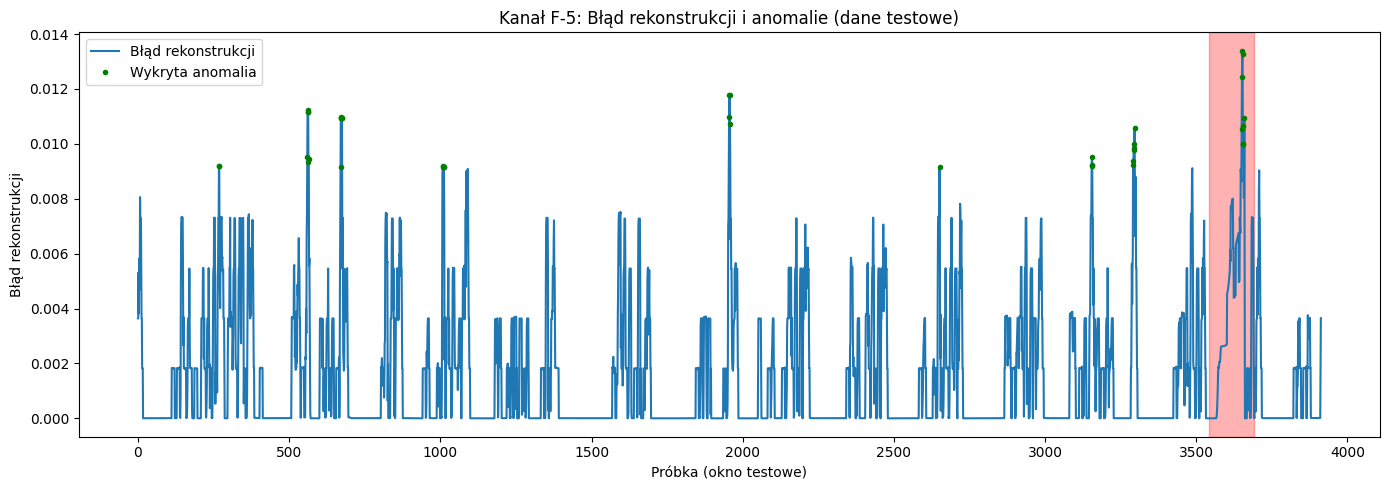

Confusion matrix (test):
[[3730   32]
 [ 143    8]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98      3762
     Anomaly       0.20      0.05      0.08       151

    accuracy                           0.96      3913
   macro avg       0.58      0.52      0.53      3913
weighted avg       0.93      0.96      0.94      3913

Wynik sprawdzania anomalii względem metadanych:
Anomalia [3550, 3700]: WYKRYTA

Czujnik: D-14
Epoch 1/80, Loss: 0.135463
Epoch 17/80, Loss: 0.005158
Epoch 33/80, Loss: 0.005182
Epoch 49/80, Loss: 0.005164
Epoch 65/80, Loss: 0.005168


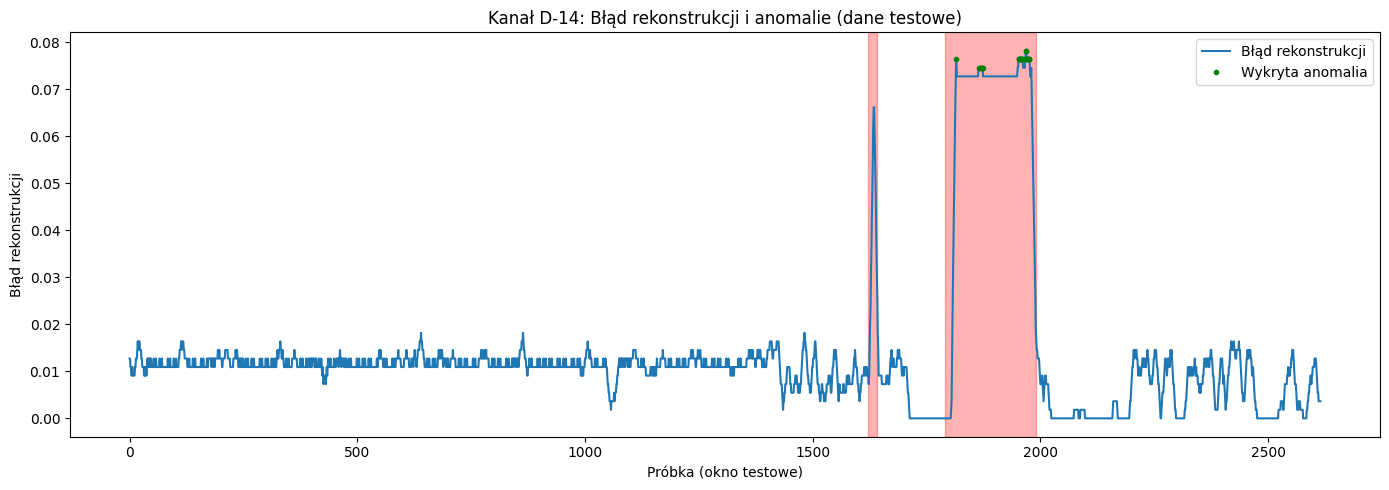

Confusion matrix (test):
[[2394    0]
 [ 195   27]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96      2394
     Anomaly       1.00      0.12      0.22       222

    accuracy                           0.93      2616
   macro avg       0.96      0.56      0.59      2616
weighted avg       0.93      0.93      0.90      2616

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1630, 1650]: NIEWYKRYTA
Anomalia [1800, 2000]: WYKRYTA

Czujnik: T-9
Epoch 1/80, Loss: 0.241497
Epoch 17/80, Loss: 0.009016
Epoch 33/80, Loss: 0.008746
Epoch 49/80, Loss: 0.007362
Epoch 65/80, Loss: 0.005331


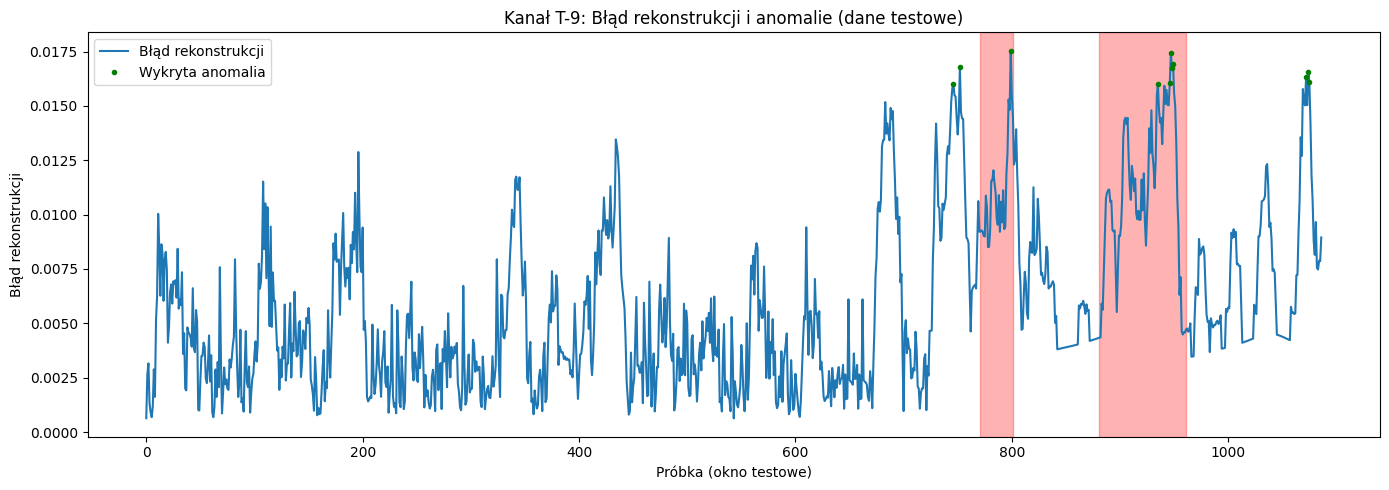

Confusion matrix (test):
[[970   5]
 [106   6]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.90      0.99      0.95       975
     Anomaly       0.55      0.05      0.10       112

    accuracy                           0.90      1087
   macro avg       0.72      0.52      0.52      1087
weighted avg       0.86      0.90      0.86      1087

Wynik sprawdzania anomalii względem metadanych:
Anomalia [780, 810]: WYKRYTA
Anomalia [890, 970]: WYKRYTA

Czujnik: P-14
Epoch 1/80, Loss: 0.140011
Epoch 17/80, Loss: 0.002370
Epoch 33/80, Loss: 0.002364
Epoch 49/80, Loss: 0.002339
Epoch 65/80, Loss: 0.002306


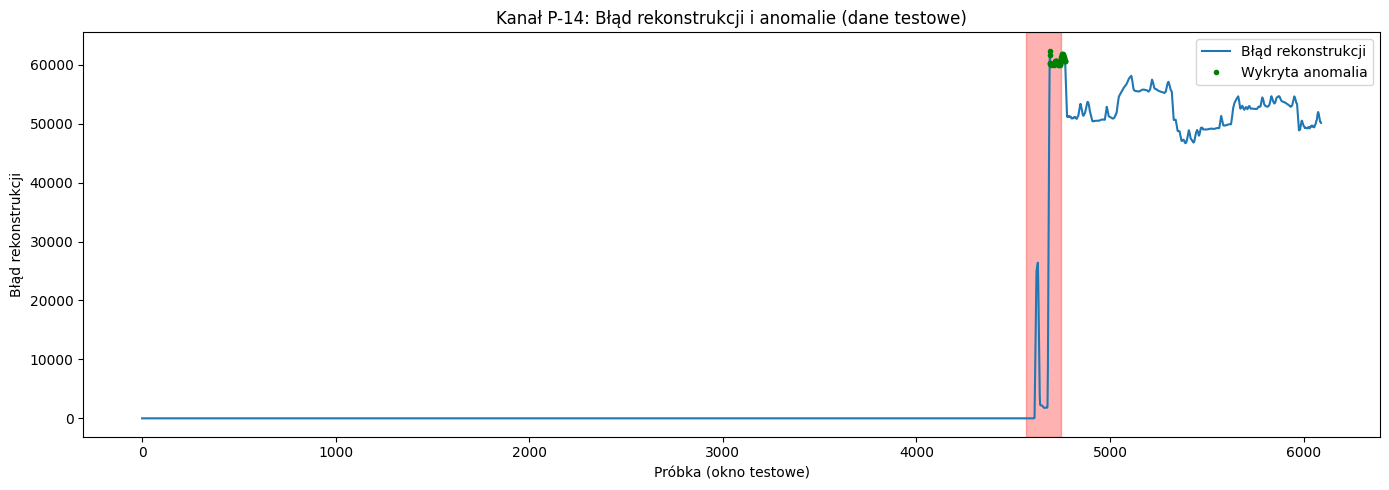

Confusion matrix (test):
[[5888   22]
 [ 142   39]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      5910
     Anomaly       0.64      0.22      0.32       181

    accuracy                           0.97      6091
   macro avg       0.81      0.61      0.65      6091
weighted avg       0.97      0.97      0.97      6091

Wynik sprawdzania anomalii względem metadanych:
Anomalia [4575, 4755]: WYKRYTA

Czujnik: T-8
Epoch 1/80, Loss: 0.244734
Epoch 17/80, Loss: 0.009872
Epoch 33/80, Loss: 0.008431
Epoch 49/80, Loss: 0.007390
Epoch 65/80, Loss: 0.006885


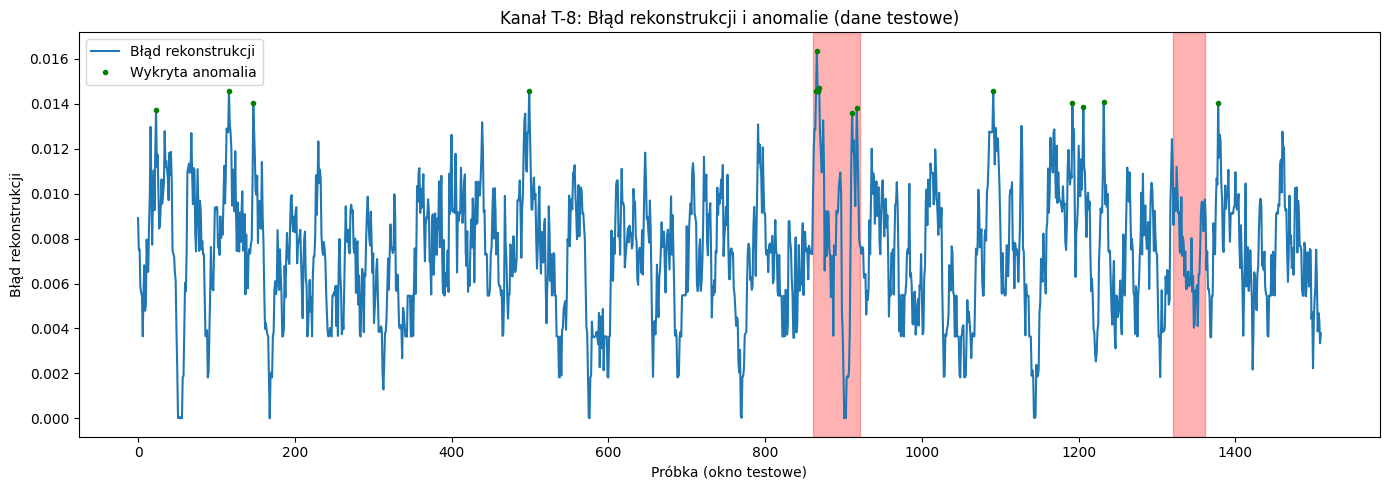

Confusion matrix (test):
[[1399    9]
 [  95    7]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      1408
     Anomaly       0.44      0.07      0.12       102

    accuracy                           0.93      1510
   macro avg       0.69      0.53      0.54      1510
weighted avg       0.90      0.93      0.91      1510

Wynik sprawdzania anomalii względem metadanych:
Anomalia [870, 930]: WYKRYTA
Anomalia [1330, 1370]: NIEWYKRYTA

Czujnik: P-11
Epoch 1/80, Loss: 0.097900
Epoch 17/80, Loss: 0.001710
Epoch 33/80, Loss: 0.001671
Epoch 49/80, Loss: 0.001662
Epoch 65/80, Loss: 0.001647


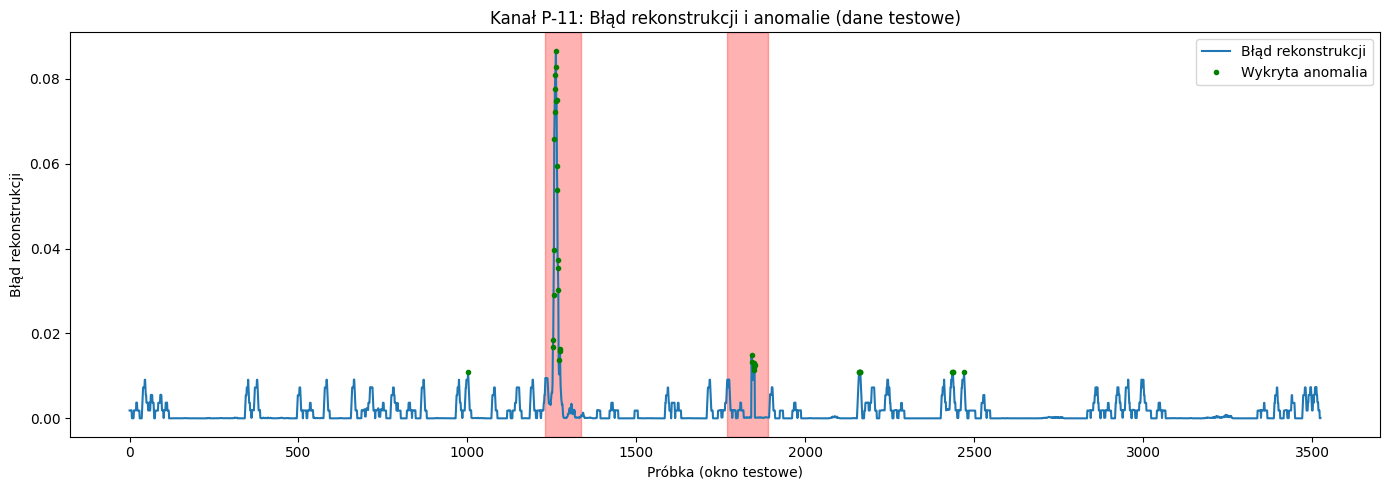

Confusion matrix (test):
[[3288   10]
 [ 202   26]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97      3298
     Anomaly       0.72      0.11      0.20       228

    accuracy                           0.94      3526
   macro avg       0.83      0.56      0.58      3526
weighted avg       0.93      0.94      0.92      3526

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1778, 1898]: WYKRYTA
Anomalia [1238, 1344]: WYKRYTA

Czujnik: D-15
Epoch 1/80, Loss: 0.166774
Epoch 17/80, Loss: 0.006777
Epoch 33/80, Loss: 0.005366
Epoch 49/80, Loss: 0.002292
Epoch 65/80, Loss: 0.001469


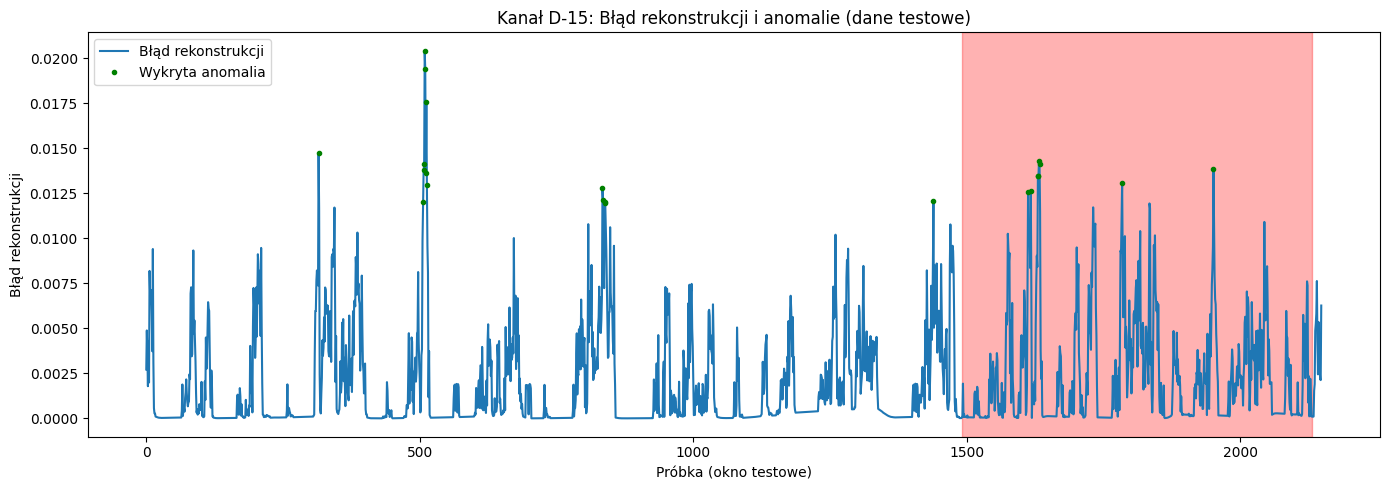

Confusion matrix (test):
[[1494   14]
 [ 633    8]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.70      0.99      0.82      1508
     Anomaly       0.36      0.01      0.02       641

    accuracy                           0.70      2149
   macro avg       0.53      0.50      0.42      2149
weighted avg       0.60      0.70      0.58      2149

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1500, 2140]: WYKRYTA

Czujnik: D-16
Epoch 1/80, Loss: 0.219786
Epoch 17/80, Loss: 0.013311
Epoch 33/80, Loss: 0.011463
Epoch 49/80, Loss: 0.010245
Epoch 65/80, Loss: 0.010067


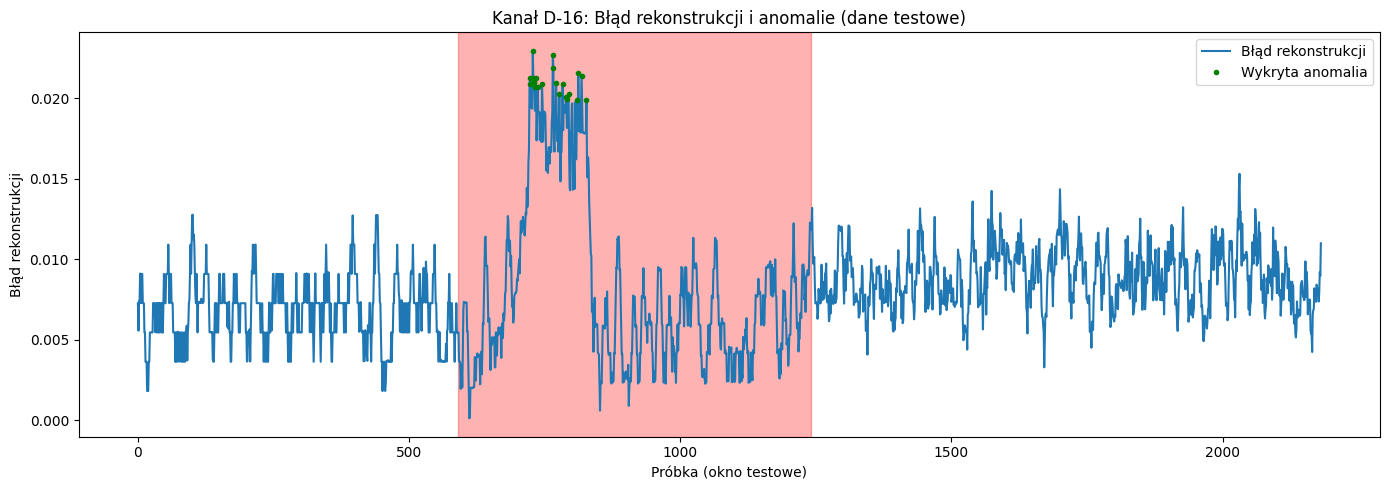

Confusion matrix (test):
[[1531    0]
 [ 629   22]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.71      1.00      0.83      1531
     Anomaly       1.00      0.03      0.07       651

    accuracy                           0.71      2182
   macro avg       0.85      0.52      0.45      2182
weighted avg       0.80      0.71      0.60      2182

Wynik sprawdzania anomalii względem metadanych:
Anomalia [600, 1250]: WYKRYTA

Czujnik: M-7
Epoch 1/80, Loss: 0.219677
Epoch 17/80, Loss: 0.008742
Epoch 33/80, Loss: 0.008463
Epoch 49/80, Loss: 0.008472
Epoch 65/80, Loss: 0.008377


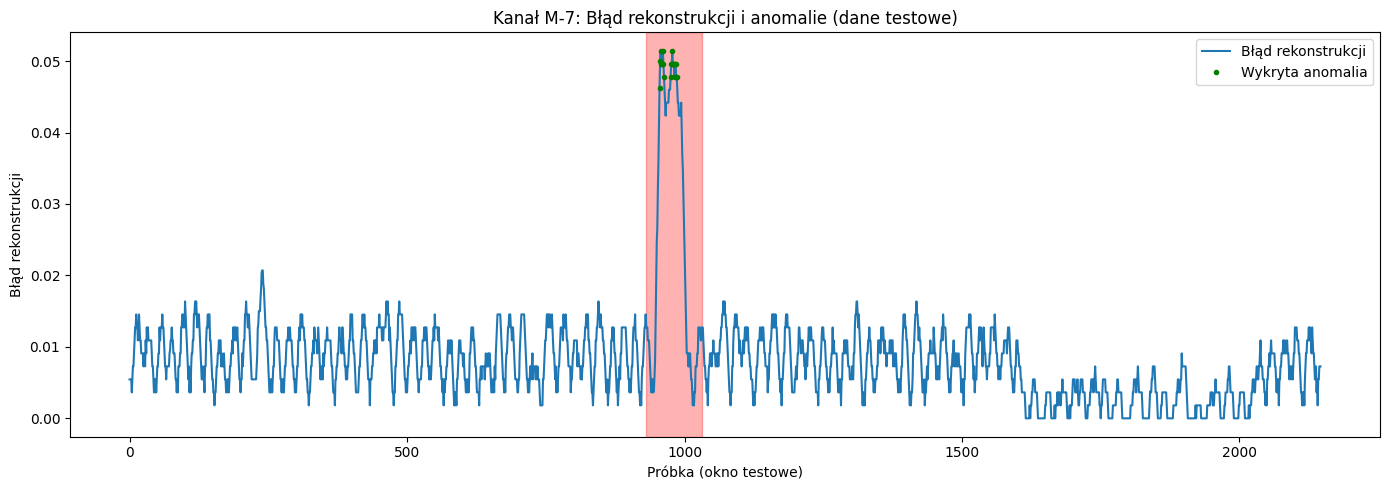

Confusion matrix (test):
[[2046    0]
 [  80   21]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98      2046
     Anomaly       1.00      0.21      0.34       101

    accuracy                           0.96      2147
   macro avg       0.98      0.60      0.66      2147
weighted avg       0.96      0.96      0.95      2147

Wynik sprawdzania anomalii względem metadanych:
Anomalia [940, 1040]: WYKRYTA

Czujnik: F-8
Epoch 1/80, Loss: 0.133864
Epoch 17/80, Loss: 0.002976
Epoch 33/80, Loss: 0.003038
Epoch 49/80, Loss: 0.003076
Epoch 65/80, Loss: 0.002395


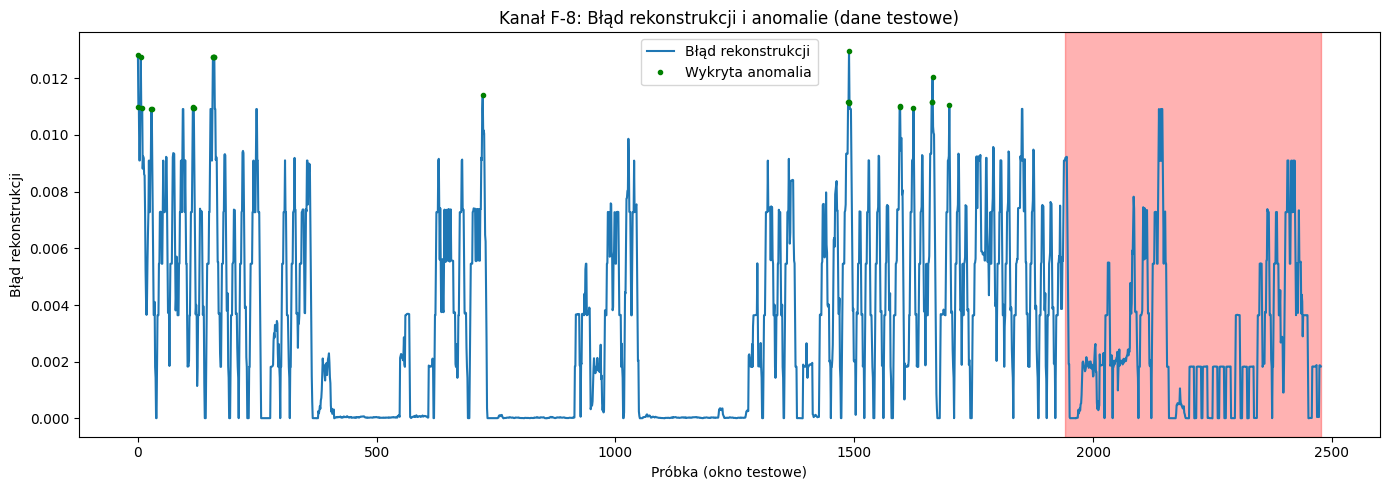

Confusion matrix (test):
[[1916   25]
 [ 537    0]]

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.78      0.99      0.87      1941
     Anomaly       0.00      0.00      0.00       537

    accuracy                           0.77      2478
   macro avg       0.39      0.49      0.44      2478
weighted avg       0.61      0.77      0.68      2478

Wynik sprawdzania anomalii względem metadanych:
Anomalia [1950, 2486]: NIEWYKRYTA

PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW
Wszystkich anomalii:: 36
Wykrytych anomalii:: 27
Niewykrytych anomali: 9


In [108]:
# Parametry do ustawienia
batch_size = 128
epochs = 80
threshold_percentile = 99
window_size = 10  
learning_rate = 1e-3

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def create_windows(data, window_size):
    return np.array([data[i:i+window_size].flatten() for i in range(len(data) - window_size + 1)])

# Definicja modelu
class UniversalAE(nn.Module):
    def __init__(self, input_dim):
        super(UniversalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

total_anomalies = 0
detected_anomalies = 0

# Pętla po wszystkich czujnikach
for sensor_name in msl_channels:
    print(f"\n{'='*40}\nCzujnik: {sensor_name}\n{'='*40}")

    # Przygotowanie danych treningowych i testowych
    sensor_train_data = msl_train_data[sensor_name]
    sensor_test_data = msl_test_data[sensor_name]

    scaler = MinMaxScaler()
    arr_norm = scaler.fit_transform(sensor_train_data)
    arr_test_norm = scaler.transform(sensor_test_data)

    # Tworzenie okien czasowych
    arr_norm_windows = create_windows(arr_norm, window_size)
    arr_test_norm_windows = create_windows(arr_test_norm, window_size)
    input_dim = sensor_train_data.shape[1] * window_size

    # Nauka modelu
    model = UniversalAE(input_dim).to(device)
    X_train = torch.tensor(arr_norm_windows, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            x_batch = batch[0]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % max(epochs // 5, 1) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.6f}")

    # Testowanie modelu
    X_test = torch.tensor(arr_test_norm_windows, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        recon = model(X_test).cpu().numpy()
    recon_error = np.mean((arr_test_norm_windows - recon) ** 2, axis=1)

    # Wykrywanie anomalii
    threshold = np.percentile(recon_error, threshold_percentile)
    predicted_anomaly = (recon_error > threshold).astype(int)

    # Prawdziwe anomalie z labeled_anomalies.csv
    anomaly_row = metadata[metadata['chan_id'] == sensor_name]
    anomaly_sequences = []
    if not anomaly_row.empty:
        anomaly_sequences = eval(anomaly_row.iloc[0]['anomaly_sequences'])

    true_anomaly = np.zeros(len(recon_error), dtype=int)
    for seq in anomaly_sequences:
        # przesunięcie indeksów o window_size-1, bo okna są krótsze niż oryginalne dane
        start, end = seq
        start = max(0, start - (window_size - 1))
        end = max(0, end - (window_size - 1))
        true_anomaly[start:min(end+1, len(true_anomaly))] = 1

    # Wizualizacja wyników
    plt.figure(figsize=(14, 5))
    plt.plot(recon_error, label="Błąd rekonstrukcji")

    for seq in anomaly_sequences:
        start, end = seq
        start = max(0, start - (window_size - 1))
        end = max(0, end - (window_size - 1))
        plt.axvspan(start, end, color='red', alpha=0.3) 

    plt.plot(np.where(predicted_anomaly == 1)[0], recon_error[predicted_anomaly == 1], 'g.', label="Wykryta anomalia")
    plt.title(f"Kanał {sensor_name}: Błąd rekonstrukcji i anomalie (dane testowe)")
    plt.xlabel("Próbka (okno testowe)")
    plt.ylabel("Błąd rekonstrukcji")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Confusion matrix (test):")
    print(confusion_matrix(true_anomaly, predicted_anomaly))
    print("\nClassification report (test):")
    print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

    # Sprawdzenie czy wykryto PRZYNAJMNIEJ JEDNĄ próbkę z każdej zdefiniowanej anomalii
    detected_ranges = []
    for seq in anomaly_sequences:
        start, end = seq
        start = max(0, start - (window_size - 1))
        end = max(0, end - (window_size - 1))
        if np.any(predicted_anomaly[start:min(end+1, len(predicted_anomaly))] == 1):
            detected_ranges.append(seq)

    print("Wynik sprawdzania anomalii względem metadanych:")
    for seq in anomaly_sequences:
        if seq in detected_ranges:
            print(f"Anomalia {seq}: WYKRYTA")
        else:
            print(f"Anomalia {seq}: NIEWYKRYTA")

    total_anomalies += len(anomaly_sequences)
    detected_anomalies += len(detected_ranges)

print("\n" + "="*40)
print("PODSUMOWANIE DLA WSZYSTKICH CZUJNIKÓW")
print(f"Wszystkich anomalii:: {total_anomalies}")
print(f"Wykrytych anomalii:: {detected_anomalies}")
print(f"Niewykrytych anomali: {total_anomalies - detected_anomalies}")
print("="*40)